In [2]:
from pathlib import Path
from sqlalchemy import create_engine, text
from tqdm import tqdm
from datetime import datetime, date, timedelta
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)
from xgboost import XGBClassifier, plot_importance

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import sys

In [4]:
from config import DB_URI
from sklearn.metrics import (
    roc_curve, RocCurveDisplay,
    precision_recall_curve, PrecisionRecallDisplay
)
from sklearn.calibration import calibration_curve

In [3]:
ROOT_DIR = Path.cwd().parent
if str(ROOT_DIR) not in sys.path:
    sys.path.append(str(ROOT_DIR))

pd.set_option('display.max_columns', None)

In [5]:
engine = create_engine(DB_URI)
connection = engine.connect()

In [55]:
connection.close()  # Закрываем сломанное соединение

connection = engine.connect()  # Открываем новое чистое соединение

In [56]:
from sqlalchemy import text

query_jet = """
SELECT 
    id,
    probability,
    data->>'identifier',
    CASE 
        WHEN business_status IS NULL THEN 0
        WHEN business_status = 'Investigation' THEN 1
        ELSE NULL
    END AS business_status_numeric,
    created_at
FROM incidents
WHERE 
    (data->>'identifier') LIKE 'S.2%'
ORDER BY id
"""

query_not_jet = """
SELECT 
    id,
    probability,
    CASE 
        WHEN business_status IS NULL THEN 0
        WHEN business_status = 'Investigation' THEN 1
        ELSE NULL
    END AS business_status_numeric,
    created_at
FROM incidents
WHERE 
    (data->>'identifier') NOT LIKE 'S.2%'
ORDER BY id
"""

df_jet = pd.read_sql_query(text(query_jet), connection)
df_not_jet = pd.read_sql_query(text(query_not_jet), connection)

print(f"Джеты: {df_jet.shape[0]} строк")
print(f"Не джеты: {df_not_jet.shape[0]} строк")


Джеты: 48691 строк
Не джеты: 311398 строк


In [57]:
count_1 = (df_jet["business_status_numeric"] == 1).sum()
print(f"Количество бизнес-статусов = 1: {count_1}")

total = len(df_jet)
print(f"Общее количество строк: {total}")

percent = (count_1 / total) * 100
print(f"Процент 1: {percent:.2f}%")

Количество бизнес-статусов = 1: 7287
Общее количество строк: 48691
Процент 1: 14.97%


In [58]:
df_jet

,id,probability,?column?,business_status_numeric,created_at
0,148600,0.0,S.262874,0,2025-04-13 14:37:36.017751
1,148676,0.0,S.279669,0,2025-04-13 14:37:44.830754
2,148709,0.0,S.278216,0,2025-04-13 14:37:49.971186
3,148742,0.0,S.246331,0,2025-04-13 14:37:53.310317
4,148795,45.0,S.271308,1,2025-04-13 14:37:59.560333
...,...,...,...,...,...
48686,508615,30.0,S.237394,0,2025-04-28 10:58:23.481977
48687,508619,24.0,S.213528,0,2025-04-28 10:58:44.321536
48688,508627,26.0,S.249903,0,2025-04-28 10:59:41.250148
48689,508634,37.0,S.219293,0,2025-04-28 11:00:19.595703


In [23]:
df_jet["created_at"] = pd.to_datetime(df_jet["created_at"])

df_jet_before_25 = df_jet[df_jet["created_at"] < "2025-04-25"]
df_jet_after_25 = df_jet[df_jet["created_at"] >= "2025-04-25"]

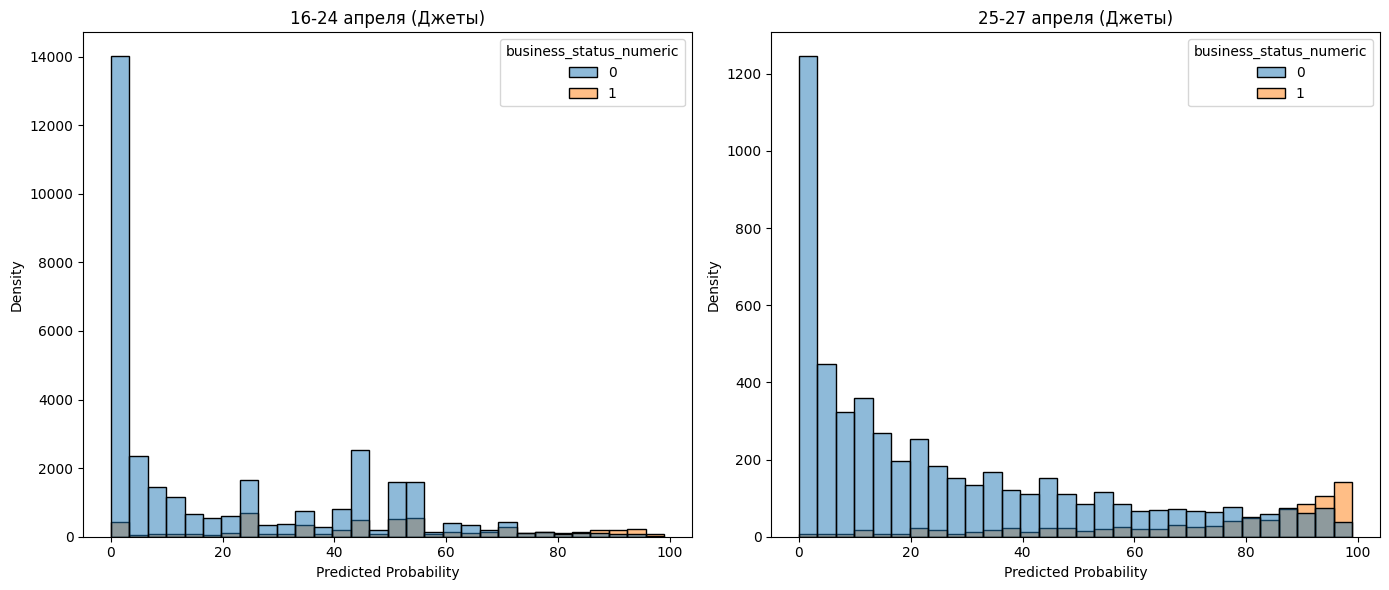

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))

# Первый период
plt.subplot(1, 2, 1)
sns.histplot(data=df_jet_before_25, x="probability", hue="business_status_numeric", bins=30, common_norm=False)
plt.title("16-24 апреля (Джеты)")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")

# Второй период
plt.subplot(1, 2, 2)
sns.histplot(data=df_jet_after_25, x="probability", hue="business_status_numeric", bins=30, common_norm=False)
plt.title("25-27 апреля (Джеты)")
plt.xlabel("Predicted Probability")
plt.ylabel("Density")

plt.tight_layout()
plt.show()


In [44]:
from sklearn.metrics import precision_score, accuracy_score

best_threshold = None
best_precision = 0
best_accuracy = 0

for threshold in range(0, 100, 1):  # 0%, 1%, ..., 99%
    t = threshold
    preds = (df_jet_after_25["probability"] > t).astype(int)
    y_true = df_jet_after_25["business_status_numeric"].fillna(0).astype(int)
    
    precision_1 = precision_score(y_true, preds, pos_label=1, zero_division=0)
    accuracy = accuracy_score(y_true, preds)
    
    if precision_1 >= 0.8:
        print(f"Threshold: {t:.2f} | Precision(1): {precision_1:.3f} | Accuracy: {accuracy:.3f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_precision = precision_1
            best_threshold = t

if best_threshold is not None:
    print(f"\nЛучший threshold 16-25 апреля: {best_threshold:.2f}% с precision(1)={best_precision:.3f} и accuracy={best_accuracy:.3f}")
else:
    print("\nНе найден threshold с precision(1) >= 0.95")


Threshold: 96.00 | Precision(1): 0.815 | Accuracy: 0.863
Threshold: 97.00 | Precision(1): 0.854 | Accuracy: 0.856
Threshold: 98.00 | Precision(1): 1.000 | Accuracy: 0.850

Лучший threshold 16-25 апреля: 96.00% с precision(1)=0.815 и accuracy=0.863


In [45]:
from sklearn.metrics import precision_score, accuracy_score

best_threshold = None
best_precision = 0
best_accuracy = 0

for threshold in range(0, 100, 1):  # 0%, 1%, ..., 99%
    t = threshold
    preds = (df_jet_before_25["probability"] > t).astype(int)
    y_true = df_jet_before_25["business_status_numeric"].fillna(0).astype(int)
    
    precision_1 = precision_score(y_true, preds, pos_label=1, zero_division=0)
    accuracy = accuracy_score(y_true, preds)
    
    if precision_1 >= 0.8:
        print(f"Threshold: {t:.2f} | Precision(1): {precision_1:.3f} | Accuracy: {accuracy:.3f}")
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_precision = precision_1
            best_threshold = t

if best_threshold is not None:
    print(f"\nЛучший threshold 25-27 апреля: {best_threshold:.2f}% с precision(1)={best_precision:.3f} и accuracy={best_accuracy:.3f}")
else:
    print("\nНе найден threshold с precision(1) >= 0.95")


Threshold: 96.00 | Precision(1): 0.827 | Accuracy: 0.850
Threshold: 97.00 | Precision(1): 0.800 | Accuracy: 0.849
Threshold: 98.00 | Precision(1): 1.000 | Accuracy: 0.849

Лучший threshold 25-27 апреля: 96.00% с precision(1)=0.827 и accuracy=0.850


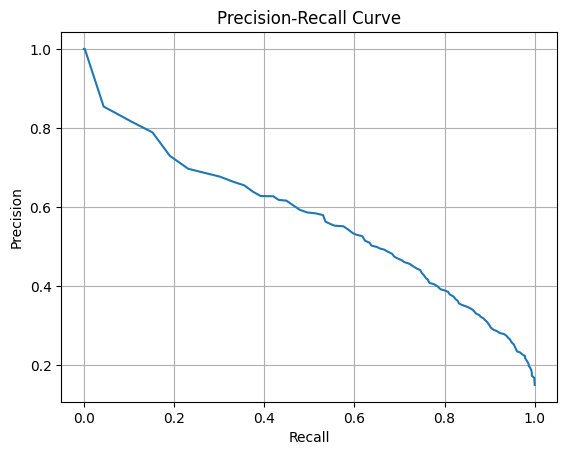

In [47]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_true = df_jet_after_25["business_status_numeric"].fillna(0).astype(int)
y_scores = df_jet_after_25["probability"]/100

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


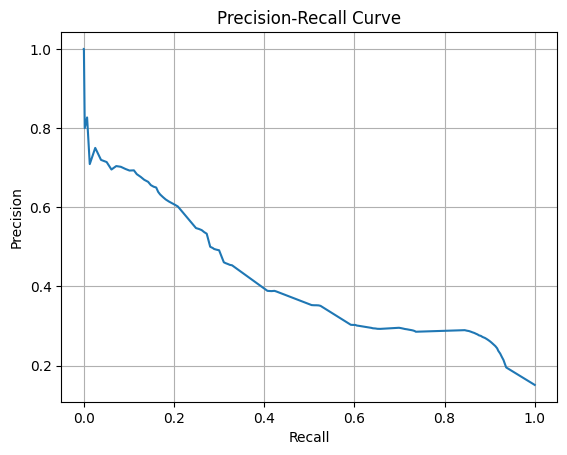

In [49]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Убираем строки, где probability был NaN
mask = df_jet_before_25["probability"].notna()

y_true = df_jet_before_25.loc[mask, "business_status_numeric"].fillna(0).astype(int)
y_scores = df_jet_before_25.loc[mask, "probability"] / 100

precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid(True)
plt.show()


____________________

In [50]:
df_jet_before_25

,id,probability,business_status_numeric,created_at
0,148600,0.0,0,2025-04-13 14:37:36.017751
1,148676,0.0,0,2025-04-13 14:37:44.830754
2,148709,0.0,0,2025-04-13 14:37:49.971186
3,148742,0.0,0,2025-04-13 14:37:53.310317
4,148795,45.0,1,2025-04-13 14:37:59.560333
...,...,...,...,...
39205,445626,85.0,0,2025-04-24 23:55:36.306383
39206,445647,14.0,0,2025-04-24 23:58:25.004889
39207,445649,76.0,0,2025-04-24 23:58:25.578176
39208,445653,21.0,0,2025-04-24 23:58:43.269006


In [51]:
df_jet_before_25.business_status_numeric.value_counts()

business_status_numeric
0    33284
1     5926
Name: count, dtype: int64